In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

slim = tf.contrib.slim

from nets import ssd_vgg_300, np_methods

In [2]:
# Input placeholder.
net_shape = (299, 299)
data_format = 'NHWC'
with tf.variable_scope('ssd'):
    inputs = tf.placeholder(tf.float32, (None, 299, 299, 3), "input")
# Evaluation pre-processing: resize to SSD net shape.

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(inputs, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt'

ssd_session = tf.Session();

ssd_session.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph('checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt.index')
saver.restore(ssd_session, ckpt_filename)

ssd_anchors = ssd_net.anchors(net_shape)
print("restored")

restored


In [3]:
print(inputs)

Tensor("ssd/input:0", shape=(?, 299, 299, 3), dtype=float32)


In [4]:
with tf.variable_scope('ssd/priors'): 
    feat_shape = tf.placeholder(tf.int32, (1), name="input_shape")
    feat_float = tf.placeholder(tf.float32, (1), name="input_div")
    offset=0.5
    ranged = tf.range(feat_shape[0])
    ones = tf.fill([feat_shape[0],feat_shape[0]], 1)
    by = tf.cast(tf.multiply(ones, ranged), tf.float32)
    bx = tf.cast(tf.multiply(ones, tf.reshape(ranged, (-1, 1))), tf.float32)
    y_d = tf.divide((by + offset), feat_float)
    y = tf.expand_dims(y_d, 2, name="y")
    x_d = tf.divide((bx + offset), feat_float)
    x = tf.expand_dims(x_d, 2, name="x")

In [5]:
with tf.Session() as sess:
    x_out, y_out = sess.run((x, y), feed_dict={feat_shape: [38], feat_float: [37.5]})

w and heights are always the same for our standard shape
[
[[ 0.07023411  0.10281222  0.04966302  0.09932604],
 [ 0.07023411  0.10281222  0.09932604  0.04966302]],
[[ 0.15050167  0.22323005  0.10642076  0.21284151  0.08689218  0.26067653],
 [ 0.15050167  0.22323005  0.21284151  0.10642076  0.26067653  0.08689218]],
[[ 0.33110368  0.41161588  0.23412566  0.46825132  0.19116279  0.57348841],
 [ 0.33110368  0.41161588  0.46825132  0.23412566  0.57348841  0.19116279]],
[[ 0.5117057   0.59519559  0.36183056  0.72366112  0.2954334   0.88630027],
 [ 0.5117057   0.59519559  0.72366112  0.36183056  0.88630027  0.2954334]],
[[ 0.69230771  0.77738154  0.48953545  0.9790709],
 [ 0.69230771  0.77738154  0.9790709   0.48953545]],
[[ 0.87290972  0.95896852  0.61724037  1.23448074],
 [ 0.87290972  0.95896852  1.23448074  0.61724037]]
]

In [6]:
"""
we are passed x,y points and a selection of widths and heights
"""
with tf.variable_scope('ssd/select'):
    l_feed = tf.placeholder(tf.float32, [None, None, None, None, 4], name="localizations")
    p_feed = tf.placeholder(tf.float32, [None, None, None, None, 21], name="predictions")
    
    d_pred = p_feed[:, :, :, :, 1:]
    d_conditions = tf.greater(d_pred, 0.5)
    d_chosen = tf.where(condition=d_conditions)
    c_index = d_chosen[:,:-1]
    
    x_feed = tf.placeholder(tf.float32, [None, None, None], name="x")
    y_feed = tf.placeholder(tf.float32, [None, None, None], name="y")
    
    h_feed = tf.placeholder(tf.float32, [None], name="h")
    w_feed = tf.placeholder(tf.float32, [None], name="w")
    
    box_shape = tf.shape(l_feed)
    box_reshape = [-1, box_shape[-2], box_shape[-1]]
    box_feat_localizations = tf.reshape(l_feed, box_reshape)
    
    box_yref = tf.reshape(y_feed, [-1, 1])
    box_xref = tf.reshape(x_feed, [-1, 1])
    
    box_dx = box_feat_localizations[:, :, 0] * w_feed * 0.1 + box_xref
    box_dy = box_feat_localizations[:, :, 1] * h_feed * 0.1 + box_yref
    box_w = w_feed * tf.exp(box_feat_localizations[:, :, 2] * 0.2)
    box_h = h_feed * tf.exp(box_feat_localizations[:, :, 3] * 0.2)

    box_ymin = box_dy - box_h / 2.
    box_xmin = box_dx - box_w / 2.
    box_xmax = box_dy + box_h / 2.
    box_ymax = box_dx + box_w / 2.

    box_stack = tf.stack([box_ymin, box_xmin, box_xmax, box_ymax], axis=1)
    
    box_transpose = tf.transpose(box_stack, [0,2,1])
    
    box_gather_reshape = tf.reshape(box_transpose, box_shape, name="reshaping")
    
    classes_selected = tf.cast(tf.transpose(d_chosen)[-1]+1, tf.float32)
    classes_expand = tf.expand_dims(classes_selected, 1)
    
    box_gather = tf.gather_nd(box_gather_reshape, c_index)
    p_gather = tf.expand_dims(tf.gather_nd(d_pred, d_chosen), 1)
    
    s_out = tf.concat([box_gather, p_gather, classes_expand], axis=1, name="output")

# Basic image input

get a local image and expand it to a 4d tensor

In [7]:
image_path = os.path.join('images/', 'street_smaller.jpg')

mean = tf.constant([123, 117, 104], dtype=tf.float32)

with tf.variable_scope('image'):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    #we want to use decode_image here but it's buggy
    decoded = tf.image.decode_jpeg(image_data, channels=None)
    normed = tf.divide(tf.cast(decoded, tf.float32), 255.0)
    batched = tf.expand_dims(normed, 0)
    resized_image = tf.image.resize_bilinear(batched, [299, 299])
    standard_size = resized_image
    graph_norm = standard_size * 255.0 - mean
    
with tf.Session() as image_session:
    raw_image, file_image, plot_image = image_session.run((decoded, graph_norm, standard_size), feed_dict={})

In [8]:
# Main image processing routine.

predictions_net, localizations_net = ssd_session.run([predictions, localisations],
                                                              feed_dict={'ssd/input:0': file_image})

l_bboxes = []

for i in range(6):
    
    box_feed = {l_feed: localizations_net[i], p_feed: predictions_net[i], \
                y_feed: ssd_anchors[i][0], x_feed: ssd_anchors[i][1], \
                h_feed: ssd_anchors[i][2], w_feed: ssd_anchors[i][3]}
    
    bboxes = ssd_session.run([s_out], feed_dict=box_feed)
    
    l_bboxes.append(bboxes[0])

bboxes = np.concatenate(l_bboxes, 0)
   
#     implement these in frontend
#     rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
#     rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)


In [9]:
print(predictions)

[<tf.Tensor 'ssd_300_vgg/softmax/Reshape_1:0' shape=(?, 38, 38, 4, 21) dtype=float32>, <tf.Tensor 'ssd_300_vgg/softmax_1/Reshape_1:0' shape=(?, 19, 19, 6, 21) dtype=float32>, <tf.Tensor 'ssd_300_vgg/softmax_2/Reshape_1:0' shape=(?, 10, 10, 6, 21) dtype=float32>, <tf.Tensor 'ssd_300_vgg/softmax_3/Reshape_1:0' shape=(?, 5, 5, 6, 21) dtype=float32>, <tf.Tensor 'ssd_300_vgg/softmax_4/Reshape_1:0' shape=(?, 3, 3, 4, 21) dtype=float32>, <tf.Tensor 'ssd_300_vgg/softmax_5/Reshape_1:0' shape=(?, 1, 1, 4, 21) dtype=float32>]


In [10]:
print(localisations)

[<tf.Tensor 'ssd_300_vgg/block4_box/Reshape:0' shape=(?, 38, 38, 4, 4) dtype=float32>, <tf.Tensor 'ssd_300_vgg/block7_box/Reshape:0' shape=(?, 19, 19, 6, 4) dtype=float32>, <tf.Tensor 'ssd_300_vgg/block8_box/Reshape:0' shape=(?, 10, 10, 6, 4) dtype=float32>, <tf.Tensor 'ssd_300_vgg/block9_box/Reshape:0' shape=(?, 5, 5, 6, 4) dtype=float32>, <tf.Tensor 'ssd_300_vgg/block10_box/Reshape:0' shape=(?, 3, 3, 4, 4) dtype=float32>, <tf.Tensor 'ssd_300_vgg/block11_box/Reshape:0' shape=(?, 1, 1, 4, 4) dtype=float32>]


In [11]:
print(bboxes)

[[  0.5007081    0.56252187   0.70076597   0.60229355   0.60587341  15.        ]
 [  0.44035906   0.30524838   0.76389545   0.39758897   0.58407801  15.        ]
 [  0.43986267   0.30554745   0.76637      0.39532521   0.82771897  15.        ]
 [  0.45552689   0.30645281   0.74762827   0.39763027   0.71318573  15.        ]
 [  0.45047742   0.30825138   0.75259      0.39705694   0.94375384  15.        ]
 [  0.3006998    0.34736252   0.8932153    0.53157413   0.89135635  15.        ]
 [  0.30254635   0.34669405   0.88748646   0.53035712   0.96856636  15.        ]
 [  0.40701213   0.64541495   0.83502448   0.77151895   0.57028908  15.        ]
 [  0.31568444   0.34429938   0.90190995   0.53564823   0.65401012  15.        ]
 [  0.3069694    0.34617701   0.90615559   0.53765237   0.52539647  15.        ]
 [  0.08574522   0.02499029   0.97233844   0.28934199   0.91821587  15.        ]
 [  0.08276385   0.0301434    0.97622627   0.2899977    0.97658509  15.        ]]


In [12]:
from simple_heatmap import create_nms

create_nms()

with tf.variable_scope('gather'):
    gather_indices = tf.placeholder(tf.int32, [None], name='indices')
    gather_values = tf.placeholder(tf.float32, [None, 6], name='values')
    gathered = tf.gather(gather_values, gather_indices, name='output')

In [20]:
nms_feed={'nms/bounds:0': bboxes, 'nms/threshold:0': [.8]}
pick = ssd_session.run(('nms/output:0'), feed_dict=nms_feed)

if bboxes.size>0 and pick.size>0:
    gather_feed={'gather/indices:0': pick, 'gather/values:0': bboxes}
    boxes = ssd_session.run(('gather/output:0'), feed_dict=gather_feed)

In [21]:
print(boxes)

[[  0.08276385   0.0301434    0.97622627   0.2899977    0.97658509  15.        ]
 [  0.30254635   0.34669405   0.88748646   0.53035712   0.96856636  15.        ]
 [  0.45047742   0.30825138   0.75259      0.39705694   0.94375384  15.        ]
 [  0.5007081    0.56252187   0.70076597   0.60229355   0.60587341  15.        ]
 [  0.40701213   0.64541495   0.83502448   0.77151895   0.57028908  15.        ]]


(532, 800, 3)


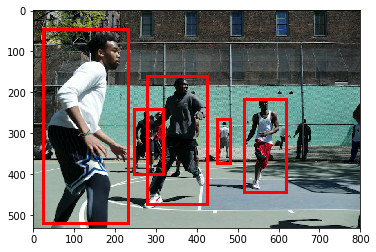

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (299,299,3))
ax.imshow(raw_image)

print(raw_image.shape)

height = raw_image.shape[0]
width = raw_image.shape[1]

for box in boxes:
    # Create a Rectangle patch
    x = box[1] * width
    y = box[0] * height
    w = (box[3]-box[1]) * width
    h = (box[2]-box[0]) * height
    
    rect = patches.Rectangle((x,y),w,h,linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [23]:
from tensorflow.python.framework import graph_util
from tensorflow.python.training import saver as saver_lib
from tensorflow.core.protobuf import saver_pb2

checkpoint_prefix = os.path.join("checkpoints", "saved_checkpoint")
checkpoint_state_name = "checkpoint_state"
input_graph_name = "input_ssd_graph.pb"
output_graph_name = "ssd.pb"
input_graph_path = os.path.join("checkpoints", input_graph_name)

saver = saver_lib.Saver(write_version=saver_pb2.SaverDef.V2)
checkpoint_path = saver.save(
  ssd_session,
  checkpoint_prefix,
  global_step=0,
  latest_filename=checkpoint_state_name)

graph_def = ssd_session.graph.as_graph_def()

from tensorflow.python.lib.io import file_io

file_io.atomic_write_string_to_file(input_graph_path, str(graph_def))
print("wroteIt")

wroteIt


In [25]:
from tensorflow.python.tools import freeze_graph

input_saver_def_path = ""
input_binary = False
output_node_names = "ssd_300_vgg/softmax/Reshape_1,"+\
    "ssd_300_vgg/softmax_1/Reshape_1,"+\
    "ssd_300_vgg/softmax_2/Reshape_1,"+\
    "ssd_300_vgg/softmax_3/Reshape_1,"+\
    "ssd_300_vgg/softmax_4/Reshape_1,"+\
    "ssd_300_vgg/softmax_5/Reshape_1,"+\
    "ssd_300_vgg/block4_box/Reshape,"+\
    "ssd_300_vgg/block7_box/Reshape,"+\
    "ssd_300_vgg/block8_box/Reshape,"+\
    "ssd_300_vgg/block9_box/Reshape,"+\
    "ssd_300_vgg/block10_box/Reshape,"+\
    "ssd_300_vgg/block11_box/Reshape,"+\
    "ssd/priors/x,"+\
    "ssd/priors/y,"+\
    "gather/output,"+\
    "nms/output,"+\
    "ssd/select/output"
    
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_graph_path = os.path.join("data", output_graph_name)
clear_devices = False

freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_graph_path, clear_devices, "")

INFO:tensorflow:Froze 71 variables.
Converted 71 variables to const ops.
685 ops in the final graph.
